<div style="
    border: 1px solid #ccc;
    border-left: 6px solid #27ae60;
    background-color: #f2fcf5;
    padding: 15px 20px;
    margin-top: 20px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    color: #2c3e50;
">
    <strong>🎯 Objective:</strong><br><br>
    Perform customer segmentation using behavioral data from credit card usage to identify distinct customer groups. Analyze the characteristics of each segment—such as spending frequency, credit utilization, and payment habits—and derive actionable business insights.<br><br>
    The goal is to support strategic decision-making by interpreting each segment in terms of its marketing potential and associated credit risk.
</div>

<div style="
    border: 1px solid #ccc;
    border-left: 6px solid #2980b9;
    background-color: #f9f9f9;
    padding: 15px 20px;
    margin-top: 20px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    color: #2c3e50;
">
    <strong>📄 Dataset Description:</strong><br><br>
    This dataset contains behavioral summaries for approximately <strong>9,000 active credit card holders</strong> over a 6-month period. Each record represents an individual customer and includes <strong>18 features</strong> capturing their credit card usage patterns, such as transaction frequency, balance behavior, and payment tendencies.
</div>

<div style="
    border: 1px solid #ccc;
    border-left: 6px solid #8e44ad;
    background-color: #34b7eb;
    padding: 15px 20px;
    margin-top: 20px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    color: #2c3e50;
">
<h2 style="text-align:center"><strong>Data Preprocessing</strong></h2>
</div>

In [1]:
import sweetviz as sv
import pandas as pd
from IPython.display import IFrame, display, HTML
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data/CC_GENERAL.csv")

In [3]:
report_path = "report.html"
report = sv.analyze(df)
report.show_html(report_path, open_browser=False)
IFrame(src=report_path, width="100%", height=1000)

                                             |                                              | [  0%]   00:00 -…

Report report.html was generated.


<div style="
    border: 1px solid #ccc;
    border-left: 6px solid #8e44ad;
    background-color: #ecf9ff;
    padding: 15px 20px;
    margin-top: 20px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    color: #2c3e50;
">
<h3 style="text-align:center"><strong>Outliers</strong></h3>
<strong>Logic-Driven Approach</strong>
<ul style="margin-left: 20px; margin-top: 10px;">
    <li>This dataset contains outliers likely stemming from reporting inconsistencies or data entry errors. The aim is not to remove high spenders or customers in default, but to exclude records with illogical or incomplete reporting — such as cases where <code>MINIMUM_PAYMENTS</code> is missing and <code>PAYMENTS</code> is zero, suggesting unreported or corrupted payment data.</li>
</ul>
</div>


In [4]:
def detect_credit_card_anomalies(df):
    anomalies = pd.DataFrame(index=df.index)
    df = df.copy()
    df.fillna(0, inplace=True)
    anomalies['purchases_without_frequency'] = (df['PURCHASES'] > 0) & (df['PURCHASES_FREQUENCY'] == 0)
    anomalies['frequency_without_purchases'] = (df['PURCHASES'] == 0) & (df['PURCHASES_FREQUENCY'] > 0)
    anomalies['purchases_without_trx'] = (df['PURCHASES'] > 0) & (df['PURCHASES_TRX'] == 0)
    anomalies['trx_without_purchases'] = (df['PURCHASES'] == 0) & (df['PURCHASES_TRX'] > 0)
    anomalies['purchases_without_frequency'] = (df['CASH_ADVANCE'] > 0) & (df['CASH_ADVANCE_FREQUENCY'] == 0)
    anomalies['frequency_without_purchases'] = (df['CASH_ADVANCE'] == 0) & (df['CASH_ADVANCE_FREQUENCY'] > 0)
    anomalies['purchases_without_trx'] = (df['CASH_ADVANCE'] > 0) & (df['CASH_ADVANCE_TRX'] == 0)
    anomalies['trx_without_purchases'] = (df['CASH_ADVANCE'] == 0) & (df['CASH_ADVANCE_TRX'] > 0)
    anomalies['min_payment_exceeds_credit_limit'] = (df['MINIMUM_PAYMENTS'] > df['CREDIT_LIMIT'])
    

    anomalies['is_anomaly'] = anomalies.any(axis=1)
    
    return anomalies

In [5]:
anomalies = detect_credit_card_anomalies(df)
df = df[~anomalies['is_anomaly']].copy()
df.shape

(8603, 18)

<div style="
    border: 1px solid #ccc;
    border-left: 6px solid #8e44ad;
    background-color: #ecf9ff;
    padding: 15px 20px;
    margin-top: 20px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    color: #2c3e50;
">
<h3 style="text-align:center"><strong>Outliers</strong></h3>
<strong>Statistical Noise Removal</strong>
<ul style="margin-left: 20px; margin-top: 10px;">
    <li>After eliminating illogical or incomplete records, statistical techniques are applied to detect and remove additional noise—extreme values unlikely to reflect real customer behavior. These are treated as data quality issues rather than meaningful anomalies.</li>
</ul>
</div>

In [6]:
corr_matrix = df.corr()
print("High correlations (>0.8):")
high_corr = corr_matrix.abs() > 0.8
for i in range(len(high_corr.columns)):
    for j in range(i+1, len(high_corr.columns)):
        if high_corr.iloc[i,j]:
            print(f"{high_corr.columns[i]} - {high_corr.columns[j]}: {corr_matrix.iloc[i,j]:.3f}")

High correlations (>0.8):
BALANCE - MINIMUM_PAYMENTS: 0.815
PURCHASES - ONEOFF_PURCHASES: 0.923
PURCHASES_FREQUENCY - PURCHASES_INSTALLMENTS_FREQUENCY: 0.859


<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    "> 
    <h4 style="margin: 0 0 10px 0; color: #2a6ca4;">Correlation & Distribution Insights</h4>
        <ul style="margin: 0; padding-left: 20px; list-style-type: disc;">
            <li><strong>High Correlation:</strong> <code>BALANCE</code> and <code>MINIMUM_PAYMENTS</code> — 0.815</li>
            <li><strong>MINIMUM_PAYMENTS:</strong> Skew = 13.6, Kurtosis = 284</li>
            <li><strong>BALANCE:</strong> Skew = 2.39, Kurtosis = 7.67</li>
        </ul>
</div>

In [7]:
# This process to find outlier not do Imputations temporarily remove NaN
df['MINIMUM_PAYMENTS_IMPUTED'] = df['MINIMUM_PAYMENTS'].isna().astype(int)
df1 = df[df['MINIMUM_PAYMENTS_IMPUTED'] == 0].copy()

In [8]:
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

model = LinearRegression()
model.fit(df1[['BALANCE']], df1['MINIMUM_PAYMENTS'])
df1['expected_payment'] = model.predict(df1[['BALANCE']])
df1['residual'] = df1['MINIMUM_PAYMENTS'] - df1['expected_payment']
### Scores how many standard deviations from the mean. In this case it is the mean of the errors
df1['z_resid'] = zscore(df1['residual'])

In [9]:
df1['anomaly'] = df1['z_resid'].abs() > 3
df1[df1['anomaly']==True].shape

(125, 23)

<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    "> 
   Since the BALANCE reflects the current ending balance, while MINIMUM_PAYMENTS represent the accumulated minimum payments over time, it's difficult to determine whether a high MINIMUM_PAYMENT is due to recent activity or past transactions. No actions will be taken
</div>

In [10]:
df1[((df1['anomaly']==True) & (df1['CREDIT_LIMIT']-df['MINIMUM_PAYMENTS']< 0) & (df1['PRC_FULL_PAYMENT']==0))]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,...,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,MINIMUM_PAYMENTS_IMPUTED,expected_payment,residual,z_resid,anomaly


<div style="
    border: 1px solid #ccc;
    border-left: 6px solid #8e44ad;
    background-color: #ecf9ff;
    padding: 15px 20px;
    margin-top: 20px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    color: #2c3e50;
">
<h3 style="text-align:center"><strong>Handle Missing Values: Minimum Payment</strong></h3>
    <strong>Imputation Method: MINIMUM PAYMENT</strong>
    <ul style="margin-left: 20px; margin-top: 10px;">
        <li>This method will use a RandomForestRegressor to predict what the missing MINIMUM_PAYMENTS should be.</li>
    </ul>
</div>
</div>

In [11]:
#Remove one Credit Nan
df = df[~df["CREDIT_LIMIT"].isna()]

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
def impute_min_payments_from_credit_usage(df):
    df = df.copy()

    df_cash = df[df['MINIMUM_PAYMENTS'].notna()]
    Q1_cash = df_cash['MINIMUM_PAYMENTS'].quantile(0.25)
    Q3_cash = df_cash['MINIMUM_PAYMENTS'].quantile(0.75)
    IQR_cash = Q3_cash - Q1_cash
    ## Normally Keeping 99% of normal distribution via Tukey rule would capture more data but I believe in this case the 
    ## Rules for minimum payment is more "standard" 
    df_cash = df_cash[(df_cash['MINIMUM_PAYMENTS'] >= Q1_cash - 1.5 * IQR_cash) &
                      (df_cash['MINIMUM_PAYMENTS'] <= Q3_cash + 1.5 * IQR_cash )]

    features_cash = ['CASH_ADVANCE', 'BALANCE', 'PURCHASES', 'CREDIT_LIMIT','PAYMENTS']
    model_cash = RandomForestRegressor()
    model_cash.fit(df_cash[features_cash], df_cash['MINIMUM_PAYMENTS'])
    # Predict for all rows
    

    # Evaluation metrics
    metrics = {}
   
    
    # purchase_preds = model_purchase.predict(df_purchase[features_purchase])
    df['PRED_MIN'] = model_cash.predict(df[features_cash])
    cash_preds = model_cash.predict(df_cash[features_cash])
    metrics = {
        'cash_model_r2': r2_score(df_cash['MINIMUM_PAYMENTS'], cash_preds),
        'cash_model_rmse': np.sqrt(mean_squared_error(df_cash['MINIMUM_PAYMENTS'], cash_preds)),
        'cash_model_feature_importances': dict(zip(features_cash, model_cash.feature_importances_)),

    }

    output_cols = ['CUST_ID', 'CASH_ADVANCE', 'PURCHASES', 'BALANCE', 'CREDIT_LIMIT', 
                   'BALANCE_FREQUENCY', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'PAYMENTS',
                   'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY',
                    'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PRC_FULL_PAYMENT',
                   'CASH_ADVANCE_FREQUENCY', 'PURCHASES_FREQUENCY',
                   'PRED_MIN','MINIMUM_PAYMENTS', 'TENURE']

    results = df[output_cols]

    return_values = (results,)
  
    return_values += (model_cash,)
    return_values +=(metrics,)

    return return_values if len(return_values) > 1 else results, None

In [13]:
df_new = impute_min_payments_from_credit_usage(df)

In [14]:
result = df_new[0][2]
from displays import display_model_results

display_model_results(
    title="MINIMUM PAYMENTS Prediction Model",
    r2=result['cash_model_r2'],
    rmse=result['cash_model_rmse'],
    feature_importances=result['cash_model_feature_importances']
)

In [15]:
df = df_new[0][0]

In [16]:
## Adding imputated values for minimum paymnet
df['MINIMUM_PAYMENTS'].fillna(df['PRED_MIN'], inplace=True)

In [17]:
df.drop(columns =["PRED_MIN"], inplace = True)


<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">There was quite a bit of messy exploration early on—it took more time than expected to fully understand the structure of the data. 
    For the imputation, this example uses a straightforward approach to demonstrate the method. Although GridSearch was considered, the default parameters ended up performing best. Onward.
</div>

<div style="
    border: 1px solid #ccc;
    border-left: 6px solid #8e44ad;
    background-color: #34b7eb;
    padding: 15px 20px;
    margin-top: 20px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    color: #2c3e50;
">
<h3 style="text-align:center"><strong>FEATURE ENGINEERING</strong></h3>

</div>
</div>

In [18]:
df['avg_purchase_amount'] = np.where(
    (df['PURCHASES_TRX'] == 0) & ((df['ONEOFF_PURCHASES'] + df['INSTALLMENTS_PURCHASES']) == 0),
   0,
    (df['ONEOFF_PURCHASES'] + df['INSTALLMENTS_PURCHASES']) / (df['PURCHASES_TRX']+1)
)

# AVERAGE_CASH_ADVANCE: Same logic for cash advances
df['average_cash_advance_amount'] = np.where(
    (df['CASH_ADVANCE_TRX'] == 0) & (df['CASH_ADVANCE'] == 0),
    0,
    df['CASH_ADVANCE'] / (df['CASH_ADVANCE_TRX'] +1)
)
df["credit_usage"] = df['BALANCE']/ (df['CREDIT_LIMIT']+1)
df['payment_to_minimum_ratio'] = (df["PAYMENTS"] / (df['MINIMUM_PAYMENTS']+1))

In [19]:
ID_COL= df["CUST_ID"]
columns_needs= list(df.columns)
columns_needs.remove("CUST_ID")
df3 = df[columns_needs].copy()

In [20]:
from sklearn.preprocessing import StandardScaler
def scale_dataframe(df):
    numeric_cols = df.select_dtypes(include='number').columns
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df[numeric_cols])
    scaled_df = pd.DataFrame(scaled_array, columns=numeric_cols, index=df.index)
    return scaled_df

df_scaled = scale_dataframe(df3)

<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">Feature Engineer and Selection Per Use Case
</div>

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
feature_sets = {
    'simple_domain': ['CREDIT_LIMIT', 'PURCHASES', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE', 'credit_usage'],
    'risk_focused': ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'payment_to_minimum_ratio', 'credit_usage'],
    'value_focused': ['CREDIT_LIMIT', 'PURCHASES', 'BALANCE', 'PURCHASES_FREQUENCY', 'TENURE'],
    'behavioral': ['ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'avg_purchase_amount','average_cash_advance_amount']
}
results = {}
for name, features in feature_sets.items():
    # Ensure features exist in your dataset
    available_features = [f for f in features if f in df_scaled.columns]
    X_domain = df_scaled[available_features]
    
    # Test clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    labels = kmeans.fit_predict(X_domain)
    
    sil_score = silhouette_score(X_domain, labels)
    results[name] = {
        'features': available_features,
        'silhouette': sil_score,
        'n_features': len(available_features)
    }

for name, result in results.items():
    print(f"{name}: {result['silhouette']:.3f} ({result['n_features']} features)")


simple_domain: 0.307 (5 features)
risk_focused: 0.450 (5 features)
value_focused: 0.367 (5 features)
behavioral: 0.472 (5 features)


In [22]:
## Two data sets for different Business use cases
top_features_risk = feature_sets["risk_focused"]
top_features_behavioral = feature_sets["behavioral"]
df_risk = df[top_features_risk]
df_behavioral = df[top_features_behavioral]
df_risk_scaled = df_scaled[top_features_risk]
df_behavioral_scaled = df_scaled[top_features_behavioral]

<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">Checking for Strong Correlations
</div>

In [23]:
corr_matrix = df_behavioral.corr()
print("High correlations (>0.8):")
high_corr = corr_matrix.abs() > 0.8
for i in range(len(high_corr.columns)):
    for j in range(i+1, len(high_corr.columns)):
        if high_corr.iloc[i,j]:
            print(f"{high_corr.columns[i]} - {high_corr.columns[j]}: {corr_matrix.iloc[i,j]:.3f}")

High correlations (>0.8):


In [24]:
corr_matrix = df_risk.corr()
print("High correlations (>0.8):")
high_corr = corr_matrix.abs() > 0.8
for i in range(len(high_corr.columns)):
    for j in range(i+1, len(high_corr.columns)):
        if high_corr.iloc[i,j]:
            print(f"{high_corr.columns[i]} - {high_corr.columns[j]}: {corr_matrix.iloc[i,j]:.3f}")

High correlations (>0.8):


<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">Finding and Removing Multi-Collinear Columns
</div>

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df_risk.select_dtypes(include=[np.number])
X_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,BALANCE,2.093044
1,PURCHASES,1.118766
2,CASH_ADVANCE,1.389297
3,payment_to_minimum_ratio,1.030988
4,credit_usage,1.601199


In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df_behavioral.select_dtypes(include=[np.number])
X_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,ONEOFF_PURCHASES,1.264850
1,INSTALLMENTS_PURCHASES,1.147577
2,CASH_ADVANCE,1.628304
3,avg_purchase_amount,1.172006
4,average_cash_advance_amount,1.634739


<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">All VIF scores are below 5. This signals low multicollinearity
</div>

In [ ]:
<div style="
    border: 1px solid #ccc;
    border-left: 6px solid #8e44ad;
    background-color: #34b7eb;
    padding: 15px 20px;
    margin-top: 20px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    color: #2c3e50;
">
<h2 style="text-align:center"><strong>ALGORITHM SELECTION</strong></h2>
</div>

<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">
    <h4 style="margin-top: 0;">Clustering Considerations</h4>
    <strong>Challenges:</strong>
    <ul style="margin-left: 20px;">
        <li>Unknown number of clusters</li>
        <li>Clusters may not have similar densities</li>
        <li>Clusters are unlikely to be spherical</li>
    </ul>
    <strong>Advantages:</strong>
    <ul style="margin-left: 20px;">
        <li>Not a high-dimensional dataset</li>
        <li>Small enough dataset to support complex algorithms</li>
    </ul>
</div>

<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">
    <h3>Hierarchical Clustering</h3>
            – Performs well with arbitrarily shaped clusters but struggles when clusters have varying densities.
</div>

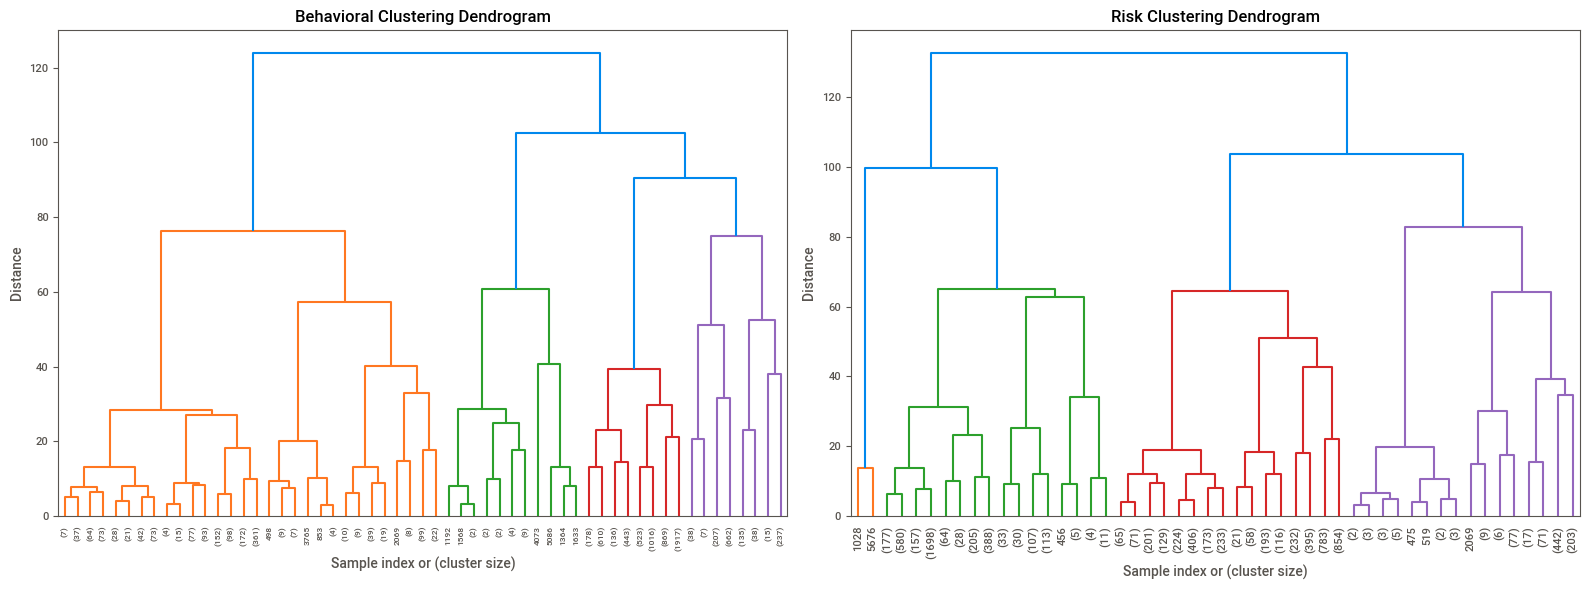

In [27]:
## Initial Look
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering

linked_behavioral = linkage(df_behavioral_scaled, method='ward')
linked_risk = linkage(df_risk_scaled, method='ward')


fig, axes = plt.subplots(1, 2, figsize=(16, 6))


dendrogram(linked_behavioral,
           truncate_mode='level',
           p=5,
           ax=axes[0])
axes[0].set_title('Behavioral Clustering Dendrogram')
axes[0].set_xlabel('Sample index or (cluster size)')
axes[0].set_ylabel('Distance')

# Second dendrogram: Risk
dendrogram(linked_risk,
           truncate_mode='level',
           p=5,
           ax=axes[1])
axes[1].set_title('Risk Clustering Dendrogram')
axes[1].set_xlabel('Sample index or (cluster size)')
axes[1].set_ylabel('Distance')

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import silhouette_score
groups = 0
max_score = 0
count_groups = 0
for x in range(50, 100):
    
    labels = fcluster(linked_behavioral, t=x,criterion='distance')
    new_groups = len(set(labels))
    if new_groups != groups:
        score = silhouette_score(df_behavioral_scaled, labels)
        if score>max_score:
            max_score = score
            count_groups = new_groups
        print(f"Behavioral Group Count: {new_groups} Silhouette score at t={x}: {score:.3f}")
        groups = new_groups
print(f"(Best Score {max_score} Group Count : {count_groups}")

Behavioral Group Count: 10 Silhouette score at t=50: 0.432
Behavioral Group Count: 9 Silhouette score at t=52: 0.435
Behavioral Group Count: 8 Silhouette score at t=53: 0.427
Behavioral Group Count: 7 Silhouette score at t=58: 0.424
Behavioral Group Count: 6 Silhouette score at t=61: 0.423
Behavioral Group Count: 5 Silhouette score at t=75: 0.404
Behavioral Group Count: 4 Silhouette score at t=77: 0.429
Behavioral Group Count: 3 Silhouette score at t=91: 0.439
(Best Score 0.43892466872514196 Group Count : 3


In [29]:
from sklearn.metrics import silhouette_score
groups = 0
max_score = 0
count_groups = 0
for x in range(50, 100):
    
    labels = fcluster(linked_risk, t=x,criterion='distance')
    new_groups = len(set(labels))
    if new_groups != groups:
        score = silhouette_score(df_risk_scaled, labels)
        if score>max_score:
            max_score = score
            count_groups = new_groups
        print(f"Risk Group Count: {new_groups} Silhouette score at t={x}: {score:.3f}")
        groups = new_groups
print(f"(Best Score {max_score} Group Count : {count_groups}")

Risk Group Count: 10 Silhouette score at t=50: 0.332
Risk Group Count: 9 Silhouette score at t=52: 0.333
Risk Group Count: 8 Silhouette score at t=63: 0.328
Risk Group Count: 6 Silhouette score at t=65: 0.335
Risk Group Count: 5 Silhouette score at t=66: 0.325
Risk Group Count: 4 Silhouette score at t=83: 0.320
(Best Score 0.3351348207974647 Group Count : 6


<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">
    <h3>Distance-Based Algorithms</h3>
            – Struggles with non-spherical clusters and varying cluster densities
</div>

<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">
    <h5>Elbow Method</h5>
            – Examine the inertia for each number of clusters
</div>

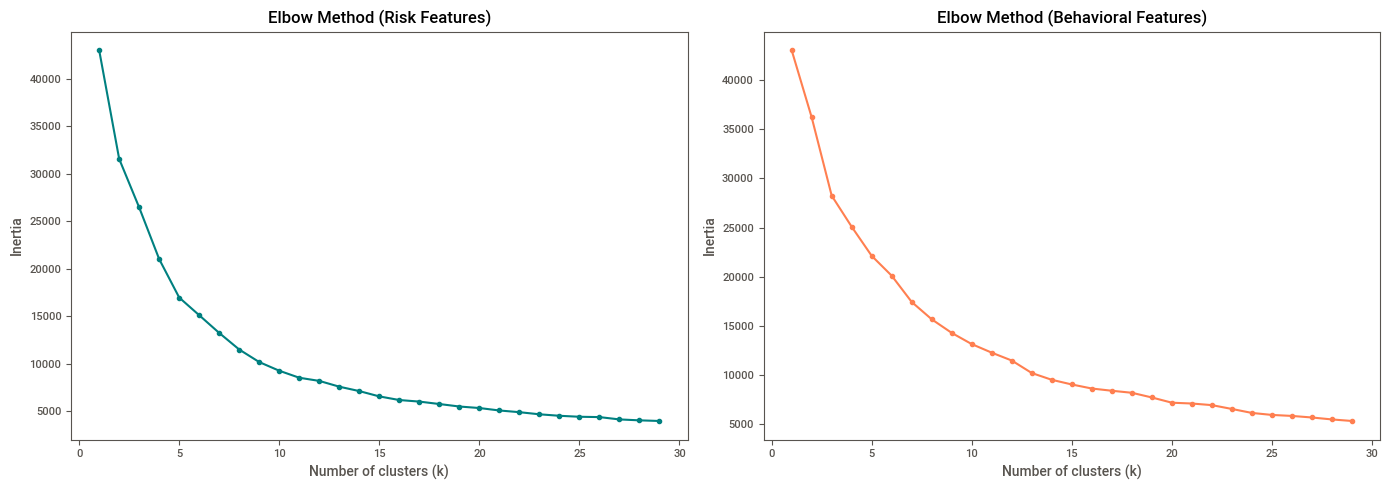

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_risk= []
inertia_behavioral = []
K_range = range(1, 30)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_risk_scaled)
    inertia_risk.append(kmeans.inertia_)
    kmeans.fit(df_behavioral_scaled)
    inertia_behavioral.append(kmeans.inertia_)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Behavioral Elbow Plot
axs[1].plot(K_range, inertia_behavioral, marker='o', color='coral')
axs[1].set_title('Elbow Method (Behavioral Features)')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Inertia')

# Risk Elbow Plot
axs[0].plot(K_range, inertia_risk, marker='o', color='teal')
axs[0].set_title('Elbow Method (Risk Features)')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')



plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import silhouette_score
groups = 0
max_score= 0
count_group = 0
for k in range(3, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_behavioral_scaled)
    score = silhouette_score(df_behavioral_scaled, labels)
    if score > max_score:
        max_score = score
        count_group = k
    print(f"Behavioral Group Count:={k}, Silhouette Score={score:.3f}")
print(f"Best Score {max_score} Group Count : {count_group}")


Behavioral Group Count:=3, Silhouette Score=0.544
Behavioral Group Count:=4, Silhouette Score=0.550
Behavioral Group Count:=5, Silhouette Score=0.472
Behavioral Group Count:=6, Silhouette Score=0.440
Behavioral Group Count:=7, Silhouette Score=0.459
Behavioral Group Count:=8, Silhouette Score=0.422
Behavioral Group Count:=9, Silhouette Score=0.448
Behavioral Group Count:=10, Silhouette Score=0.449
Behavioral Group Count:=11, Silhouette Score=0.410
Behavioral Group Count:=12, Silhouette Score=0.398
Behavioral Group Count:=13, Silhouette Score=0.393
Behavioral Group Count:=14, Silhouette Score=0.395
Best Score 0.5498191834997902 Group Count : 4


In [32]:
from sklearn.metrics import silhouette_score
groups = 0
max_score= 0
count_group = 0
for k in range(3, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_risk_scaled)
    score = silhouette_score(df_risk_scaled, labels)
    if score > max_score:
        max_score = score
        count_group = k
    print(f"Risk Group Count Count:={k}, Silhouette Score={score:.3f}")
print(f"Best Score {max_score} Group Count : {count_group}")


Risk Group Count Count:=3, Silhouette Score=0.422
Risk Group Count Count:=4, Silhouette Score=0.429
Risk Group Count Count:=5, Silhouette Score=0.450
Risk Group Count Count:=6, Silhouette Score=0.446
Risk Group Count Count:=7, Silhouette Score=0.458
Risk Group Count Count:=8, Silhouette Score=0.461
Risk Group Count Count:=9, Silhouette Score=0.470
Risk Group Count Count:=10, Silhouette Score=0.393
Risk Group Count Count:=11, Silhouette Score=0.406
Risk Group Count Count:=12, Silhouette Score=0.385
Risk Group Count Count:=13, Silhouette Score=0.389
Risk Group Count Count:=14, Silhouette Score=0.381
Best Score 0.47004604245799114 Group Count : 9


In [33]:
# Create comparison DataFrame
df_compare_behavioral = pd.DataFrame(df_behavioral_scaled)
df_compare_risk = pd.DataFrame(df_risk_scaled)
# KMeans
kmeans_behavioral = KMeans(n_clusters=5, random_state=42)
df_compare_behavioral['kmeans'] = kmeans_behavioral.fit_predict(df_behavioral_scaled)
kmeans_risk = KMeans(n_clusters=5, random_state=42)
df_compare_risk['kmeans'] = kmeans_risk.fit_predict(df_risk_scaled)

# Agglomerative
agglo_behavioral = AgglomerativeClustering(n_clusters=3, linkage='ward')
df_compare_behavioral['agglo'] = agglo_behavioral.fit_predict(df_behavioral_scaled)
agglo_risk = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_compare_risk['agglo'] = agglo_risk.fit_predict(df_risk_scaled)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,  random_state=42)
X_pca_b = pca.fit_transform(df_behavioral_scaled)
X_pca_r = pca.fit_transform(df_risk_scaled)

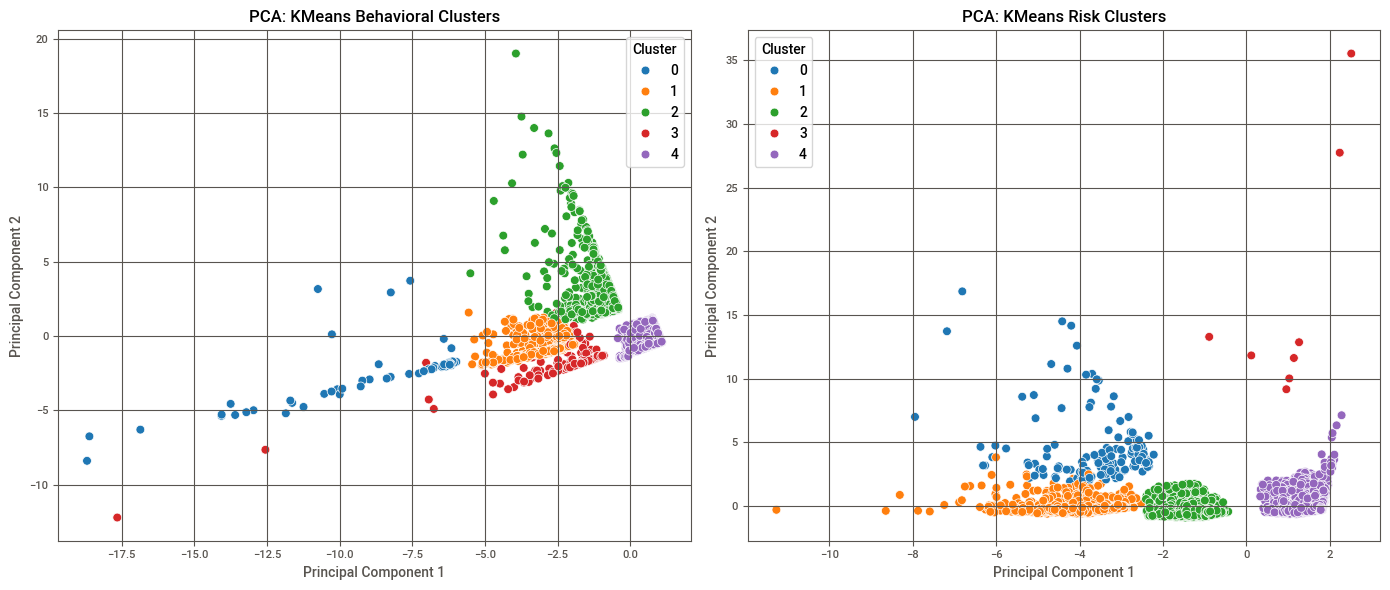

In [35]:
# show the 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# First subplot: Behavioral Clusters
sns.scatterplot(
    x=X_pca_b[:, 0], y=X_pca_b[:, 1],
    hue=df_compare_behavioral['kmeans'],
    palette="tab10", s=40, ax=axes[0]
)
axes[0].set_title("PCA: KMeans Behavioral Clusters")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].legend(title="Cluster")
axes[0].grid(True)

# Second subplot: Risk Clusters
sns.scatterplot(
    x=X_pca_r[:, 0], y=X_pca_r[:, 1],
    hue=df_compare_risk['kmeans'],
    palette="tab10", s=40, ax=axes[1]
)
axes[1].set_title("PCA: KMeans Risk Clusters")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(title="Cluster")
axes[1].grid(True)

plt.tight_layout()
plt.show()

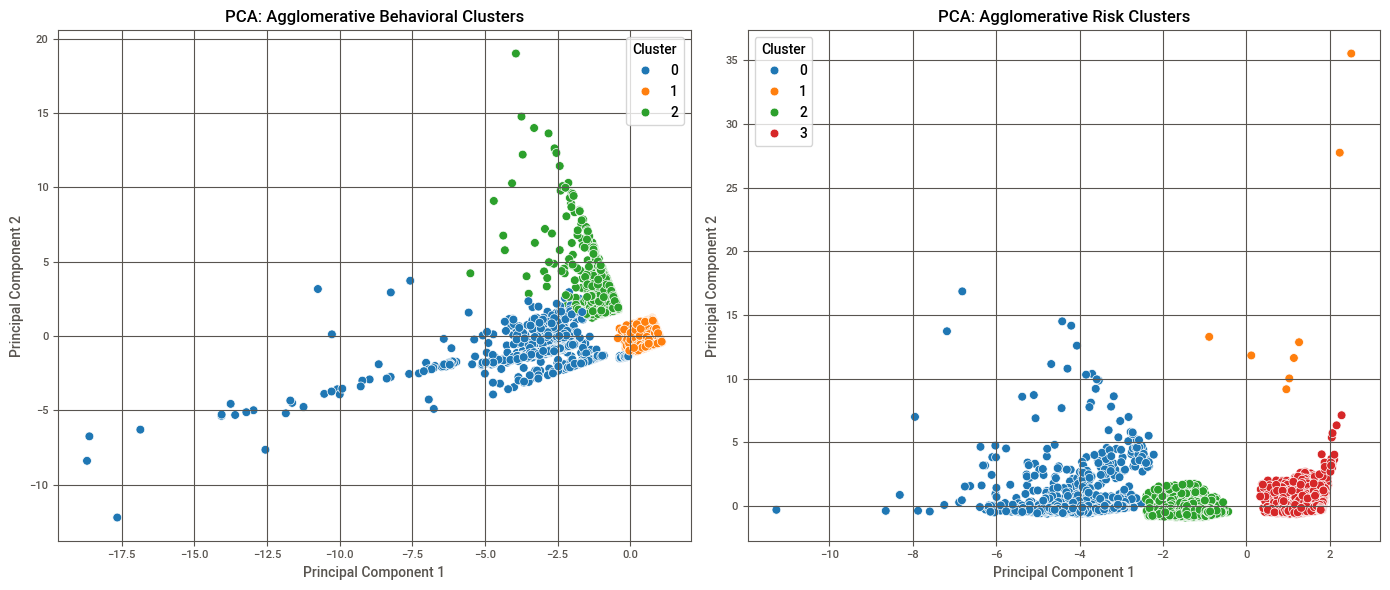

In [36]:


fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# First subplot: Agglomerative Behavioral Clusters
sns.scatterplot(
    x=X_pca_b[:, 0], y=X_pca_b[:, 1],
    hue=df_compare_behavioral['agglo'],
    palette="tab10", s=40, ax=axes[0]
)
axes[0].set_title("PCA: Agglomerative Behavioral Clusters")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].legend(title="Cluster")
axes[0].grid(True)

# Second subplot: Agglomerative Risk Clusters
sns.scatterplot(
    x=X_pca_r[:, 0], y=X_pca_r[:, 1],
    hue=df_compare_risk['agglo'],
    palette="tab10", s=40, ax=axes[1]
)
axes[1].set_title("PCA: Agglomerative Risk Clusters")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(title="Cluster")
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Agglomerative Clusters

In [37]:
df_behavioral_unscaled =  df_behavioral.copy() 
df_risk_unscaled =  df_risk.copy() 

df_behavioral_unscaled['agglo'] = df_compare_behavioral['agglo']
df_risk_unscaled['agglo'] = df_compare_risk['agglo']
# Summary statistics for each cluster
cluster_summary_behavioral = df_behavioral_unscaled.groupby('agglo').agg(['mean'])
cluster_summary_risk = df_risk_unscaled.groupby('agglo').agg(['mean'])

behavior_labels = {
    0: "Affluent All-Purpose Spenders",
    1: "Everyday Responsible Users",
    2: "Cash-Dependent Borrowers",
}
risk_labels = {
    0: "Affluent All-Purpose Spenders",
    1: "High Liquidity, Full-Balance Payers ",
    2: "High Risk, Limit-Reaching Users",
    3: "Low Exposure, Highly Disciplined"
}


cluster_summary_behavioral.index = cluster_summary_behavioral.index.map(behavior_labels)
cluster_summary_behavioral.index.name = "Behavioral Cluster"

cluster_summary_risk.index = cluster_summary_risk.index.map(risk_labels)
cluster_summary_risk.index.name = "Risk Cluster"

import pandas as pd
pd.set_option('display.max_columns', None)  # To see all columns
display(HTML("""
    <div style= padding:10px 0;">
      <h5 style="font-size:28px; color:#2d3436; border-bottom:2px solid #dfe6e9; display:inline-block;">
         Behavioral Cluster Summary Agglomerative
      </h5>
    </div>
"""))
display(cluster_summary_behavioral)
display(df_behavioral_unscaled['agglo'].value_counts().sort_index())
display(HTML("""
    <div style= padding:10px 0;">
      <h4 style="font-size:28px; color:#2d3436; border-bottom:2px solid #dfe6e9; display:inline-block;">
        Risk Cluster Summary Agglomerative
      </h4>
    </div>
"""))
display(cluster_summary_risk)
display(df_risk_unscaled['agglo'].value_counts().sort_index())

,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,avg_purchase_amount,average_cash_advance_amount
,mean,mean,mean,mean,mean
Behavioral Cluster,,,,,
Affluent All-Purpose Spenders,2507.209540,1546.537200,531.201587,165.315631,75.692913
Everyday Responsible Users,263.570703,197.641196,453.700157,39.795978,76.330976
Cash-Dependent Borrowers,241.794029,126.352035,5156.767914,32.238374,726.985679


0    1325
1    6315
2     963
Name: agglo, dtype: int64

,BALANCE,PURCHASES,CASH_ADVANCE,payment_to_minimum_ratio,credit_usage
,mean,mean,mean,mean,mean
Risk Cluster,,,,,
Affluent All-Purpose Spenders,5625.925171,2693.140678,4748.911556,5.901552,0.610389
"High Liquidity, Full-Balance Payers",36.521894,346.440000,3125.538031,863.016648,0.003968
"High Risk, Limit-Reaching Users",2136.038581,577.488159,930.639887,1.947658,0.719472
"Low Exposure, Highly Disciplined",389.126758,935.133689,293.472538,8.483504,0.103239


0     929
1       8
2    2901
3    4765
Name: agglo, dtype: int64

### KMean Clusters

In [ ]:

df_behavioral_unscaled2 =  df_behavioral.copy() 
df_risk_unscaled2 =  df_risk.copy() 

df_behavioral_unscaled2['kmeans'] = df_compare_behavioral['kmeans']
df_risk_unscaled2['kmeans'] = df_compare_risk['kmeans']

# Summary statistics for each cluster
cluster_summary_behavioral2 = df_behavioral_unscaled2.groupby('kmeans').agg(['mean'])
cluster_summary_risk2 = df_risk_unscaled2.groupby('kmeans').agg(['mean'])

behavioral_labels = {
    0: "Premium or Corporate Users",
    1: "Established Active Spenders",
    2: "Cash-Driven Risk Users",
    3: "Selective Big-Ticket Buyers",
    4: "Budget-Conscious General Users",
}
risk_labels = {
    0: "High Spenders with Healthy Repayment",
    1: "At-Risk Revolvers with Heavy Cash Dependence",
    2: "Overextended Mid-Range Users",
    3: "Liquidity-Rich, Full Balance Payers",
    4: "Low Utilization, Low Risk Users",

}
cluster_summary_behavioral2.index = cluster_summary_behavioral2.index.map(behavioral_labels)
cluster_summary_behavioral2.index.name = "Behavioral Cluster"

cluster_summary_risk2.index = cluster_summary_risk2.index.map(risk_labels)
cluster_summary_risk2.index.name = "Risk Cluster"
import pandas as pd
pd.set_option('display.max_columns', None)  # To see all columns
display(HTML("""
    <div style= padding:10px 0;">
      <h5 style="font-size:28px; color:#2d3436; border-bottom:2px solid #dfe6e9; display:inline-block;">
         Behavioral Cluster Summary Kmeans
      </h5>
    </div>
"""))
display(cluster_summary_behavioral2)
display(df_behavioral_unscaled2['kmeans'].value_counts().sort_index())
display(HTML("""
    <div style= padding:10px 0;">
      <h4 style="font-size:28px; color:#2d3436; border-bottom:2px solid #dfe6e9; display:inline-block;">
        Risk Cluster Summary Kmeans
      </h4>
    </div>
"""))
display(cluster_summary_risk2)
display(df_risk_unscaled2['kmeans'].value_counts().sort_index())

<div style="
    border: 1px solid #ccc;
    border-left: 6px solid #8e44ad;
    background-color: #34b7eb;
    padding: 15px 20px;
    margin-top: 20px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    color: #2c3e50;
">
<h2 style="text-align:center"><strong>Market Strategies</strong></h2>
</div>

<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">
    <h3 style="text-align: center;">Behavioral Summaries</h3>
    <h4 style="margin-top: 0;">Premium or Corporate Users</h4>
    <strong>Marketing Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>Promote premium rewards programs (travel, luxury perks, exclusive events)</li>
        <li>Offer personalized concierge services or corporate cards</li>
        <li>Emphasize high credit limits and business-friendly features</li>
    </ul>
    <h4 style="margin-top: 0;">Established Active Spenders</h4>
    <strong>Marketing Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>Encourage loyalty through cashback or points-based rewards</li>
        <li>Upsell premium card tiers or installment plans for large purchases</li>
        <li>Offer promotions on categories they frequent (e.g., dining, travel)</li>
    </ul>
    <h4 style="margin-top: 0;">Cash-Driven Risk Users</h4>
    <strong>Marketing Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>Encourage loyalty through cashback or points-based rewards</li>
        <li>Offer promotions on categories they frequent (Casinos)</li>
    </ul>
    <h4 style="margin-top: 0;">Selective Big-Ticket Buyers</h4>
    <strong>Marketing Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>Promote buy-now-pay-later or installment financing</li>
        <li>Offer exclusive limited-time deals and flash sales</li>
    </ul>
    <h4 style="margin-top: 0;"> Budget-Conscious General Users</h4>
    <strong>Marketing Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>Offer secured or starter credit cards</li>
        <li>Educate on rewards accumulation through frequent small purchases</li>
        <li>Promote low or no annual fee cards</li>
    </ul>
</div>	

<div style="
        border: 1px solid #ccc;
        border-left: 6px solid #3498db;
        background-color: #ecf9ff;
        padding: 15px 20px;
        margin-top: 20px;
        font-family: 'Segoe UI', sans-serif;
        font-size: 15px;
        color: #2c3e50;
    ">
    <h3 style="text-align: center;">Risk Summaries</h3>
    <h4 style="margin-top: 0;">High Spenders with Healthy Repayment</h4>
    <strong>Risk Management Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>Low-to-moderate risk, monitor for spending spikes</li>
        <li>Maintain regular credit reviews with possible limit increases</li>
    </ul>
    <h4 style="margin-top: 0;">At-Risk Revolvers with Heavy Cash Dependence</h4>
    <strong> Risk Management Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>High risk: monitor for missed payments</li>
        <li>Reduce exposure with conservative credit limits or graduated repayment structures</li>
    </ul>
    <h4 style="margin-top: 0;">Overextended Mid-Range Users</h4>
    <strong>Risk Management Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>Flag for credit counseling or proactive risk alerts</li>
        <li>Consider adjusting terms (e.g., lower APR with payment incentives)</li>
    </ul>
    <h4 style="margin-top: 0;">Liquidity-Rich, Full Balance Payers</h4>
    <strong>Risk Management Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>Very low risk — excellent customers</li>
        <li>Prioritize for retention and lifetime value enhancement</li>
    </ul>
    <h4 style="margin-top: 0;">Low Utilization, Low Risk Users</h4>
    <strong>Risk Management Strategy:</strong>
    <ul style="margin-left: 20px;">
        <li>Minimal risk — use as a baseline for safe profile benchmarking</li>
        <li>Minimal intervention unless usage or repayment behavior shifts</li>
    </ul>
</div>	